In [1]:
## 

import sympy as sy
import math
#sy.init_printing()

#x = sy.Symbol("x")
w_1 = [61, 45, 42, 56, 48, 50]
s = len(w_1)
t = 2


def poly_coeff_from_roots(roots):
    coeffs = []
    
    # Go through all the roots
    n = len(roots)
    #print(n)
    
    # Generate the result Polynomial, which initially is set to -roots[0] + x :: index of the list can be seen as power of x
    coeffs.insert(0, (-1)*roots[0])
    coeffs.insert(1,1)
    
    # Continue multiplying -roots[i] + x
    i = 1
    while i < n:
        # right shift, equivalent to multiplying x, the index increased 1 as the result
        coeffs.insert(0,0)        
        j = 0
        while j < (len(coeffs) - 1):
            # mu
            coeffs[j] = coeffs[j] + coeffs[j+1] * (-1) * roots[i]
            j = j + 1

        i = i + 1
    return coeffs[::-1] 

# def poly_coeff_from_roots(w):
#     """
#     return coefficient of poly...
#     """
#     poly = 1
#     for w_i in w:
#         poly = poly*(x-w_i) 
        
#     poly = sy.Poly(poly, x)   #Alternative: sy.expand(poly)  .coeff(x,4) --- does not give all coefficients at the same time
#     #print("Poly: = ", poly)

#     #print("Poly: Coefficients = ", poly.coeffs(), "\n")

#     return poly.coeffs()
print(poly_coeff_from_roots(w_1))
###############################################################
sent_coeffs = poly_coeff_from_roots(w_1)[0:4] #.coeffs()
#print("Sent Coefficients:", sent_coeffs)

# poly_2 = x**s
# for i in range(t):
#     poly_2 = poly_2 + sent_coeffs[i] * x**(s-i-1)

# poly_2 = sy.Poly(poly_2)
#print("Ploy:2 = ", poly_2)
#print(poly_2.subs({x: 1}))

w_2 = [60, 44, 43, 55, 48, 51]

# mult = []
# for w_i in w_2:
#     mult.append((w_i, poly_2.subs({x: w_i})))
#print("Evaluated Poly:2 = ", mult, "\n")

###############################################################
#print("\n\n\n\n\n\n")

# for a in range(s-t-1): #-1
    
#     poly_3 = poly_from_val([i for i,j in mult[a:a+t]]) #+1
#     #poly_3 = 1
#     # for i,j in mult[a:a+t+1]:
#     #     #for k in range(s-t-1, 0, -1):
#     #     poly_3 = poly_3 * (x**k - i)
#     # poly_3 = sy.Poly(poly_3)
#     print(poly_3,'\n')

def get_coeff_list(c, w, s, n, v):
    """
    c - sent coeffs
    w - secondary list at second device
    s - size of w ##### ## b
    n - number of roots to generate s-(t/2)
    v - number of varations of roots 

    ### IMPORTANT: CAN ONLY CORRECT ONE ERROR or t/2 errors
    """
    result = []
    #print(c)
    for i in range(0, s-n, 1):
        r_w = w[i: i+n] # values of w in the window - to find root of...
        match_cnt = 0  
        err_cnt = 1 # this is a cludge
        for err_idx in range(n):
            removed_r = r_w[err_idx]
            k = int(math.pow((2 * v + 1), (n-1)))
            #print(k)
            while k > 0:
                temp_list = r_w.copy()
                #temp_list.remove(removed_r)
                temp_variation = k - 1

                for l in range(n-1):
                    temp_list[l] = temp_list[l] + (temp_variation % (2 * v + 1)) - v
                    temp_variation = temp_variation // (2 * v + 1)
                #print(temp_list)
                residue_coeff = poly_coeff_from_roots(temp_list)
                #print(residue_coeff)
                addd_rt = (-1) * (c[1] - residue_coeff[1])
                temp_list.insert(err_idx,addd_rt)
                residue_coeff = poly_coeff_from_roots(temp_list)
                #print(residue_coeff)
                k = k - 1
                if(residue_coeff not in result):
                    #print(residue_coeff)
                    coeff_check = True
                    for i_t in range(t+1):
                        if(c[i_t+1] != residue_coeff[i_t+1]): # or not coeff_check
                            coeff_check = False
                            break
                    if(coeff_check):
                        result.append(residue_coeff)
                    # if(c[1] == residue_coeff[1] and c[2] == residue_coeff[2] and c[3] == residue_coeff[3]):
                    #     print(residue_coeff, c)
                    #     result.append(residue_coeff)
            # while k > 0:
            #     temp_list = r_w.copy()
            #     #temp_list.remove(removed_r)
            #     temp_variation = k - 1

            #     for l in range(n-1):
            #         temp_list[l] = temp_list[l] + (temp_variation % (2 * v + 1)) - v
            #         temp_variation = temp_variation // (2 * v + 1)
            #     #print(temp_list)
            #     residue_coeff = poly_coeff_from_roots(temp_list)
            #     #print(residue_coeff)
            #     addd_rt = (-1) * (c[2] - residue_coeff[2])
            #     temp_list.insert(err_idx,addd_rt)
            #     residue_coeff = poly_coeff_from_roots(temp_list)
            #     #print(residue_coeff)
            #     k = k - 1
            #     if(residue_coeff not in result):
            #         #print(residue_coeff)
            #         if(c[1] == residue_coeff[1] and c[2] == residue_coeff[2] and c[3] == residue_coeff[3]):
            #             result.append(residue_coeff)
    return result
w_2 = [60, 44, 43, 55, 48, 51]
get_coeff_list(c=sent_coeffs, w=w_2, s=s, n=int(s-(t/2)), v=2)

[1, -302, 37877, -2525452, 94415796, -1876684320, 15494976000]


[[1, -302, 37877, -2525452, 94415796, -1876684320, 15494976000]]

In [2]:
# Coeff function -- failed
def poly_coeff_from_roots(roots):
    coeffs = []
    
    # Go through all the roots
    n = len(roots)
    #print(n)
    
    # Generate the result Polynomial, which initially is set to -roots[0] + x :: index of the list can be seen as power of x
    coeffs.insert(0, (-1)*roots[0])
    coeffs.insert(1,1)
    
    # Continue multiplying -roots[i] + x
    i = 1
    while i < n:
        # right shift, equivalent to multiplying x, the index increased 1 as the result
        coeffs.insert(0,0)        
        j = 0
        while j < (len(coeffs) - 1):
            # mu
            coeffs[j] = coeffs[j] + coeffs[j+1] * (-1) * roots[i]
            j = j + 1

        i = i + 1
    return coeffs[::-1] 
#print(poly_coeff_from_roots([1,2,3,4,5]))


In [82]:
import math
# Full IJS usage

def poly_coeff_from_roots(roots):
    coeffs = []
    
    # Go through all the roots
    n = len(roots)
    #print(n)
    
    # Generate the result Polynomial, which initially is set to -roots[0] + x :: index of the list can be seen as power of x
    coeffs.insert(0, (-1)*roots[0])
    coeffs.insert(1,1)
    
    # Continue multiplying -roots[i] + x
    i = 1
    while i < n:
        # right shift, equivalent to multiplying x, the index increased 1 as the result
        coeffs.insert(0,0)        
        j = 0
        while j < (len(coeffs) - 1):
            # mu
            coeffs[j] = coeffs[j] + coeffs[j+1] * (-1) * roots[i]
            j = j + 1

        i = i + 1
    return coeffs[::-1]  ## reverse list from highest power coefficient to lowest

#print(poly_coeff_from_roots([1,2,3,4,5]))
##################################################################################################################
def get_coeff_list(c, w, t, v):
    """
    c - sent coeffs
    w - secondary list at second device

    s, n,
    s - size of w ##### ## b
    n - window size for root selection (not used -- same as s) #### number of roots to generate s-(t/2)

    v - number of varations of roots 
    ### IMPORTANT: CAN ONLY CORRECT ONE ERROR or t/2 errors
    """
    ##################
    s = len(w)
    n = s 
    #print(c, w, s, n, t, v)
    ##################

    result = [] # coefficients found
    corr_seq = []
    #print(c)
    # # For range finding on second device (not used if window is fixed or full)
    #for i in range(0, s-n+1, 1):
        #r_w = w[i: i+n] # values of w in the window - to find root of... (should be full - in algo.)
    ### Indent if using range -- till before return
    r_w = w.copy()
    #print(r_w)
    for err_idx in range(n):
        removed_r = r_w[err_idx]
        k = int(math.pow((2 * v + 1), (n-1)))
        #print(k)
        while k > 0:
            temp_list = r_w.copy()
            temp_list.remove(removed_r)
            temp_variation = k - 1

            for l in range(n-1):
                temp_list[l] = temp_list[l] + (temp_variation % (2 * v + 1)) - v
                temp_variation = temp_variation // (2 * v + 1)
            #print(temp_list)
            residue_coeff = poly_coeff_from_roots(temp_list)
            #print(residue_coeff)
            addd_rt = (-1) * (c[1] - residue_coeff[1])
            temp_list.insert(err_idx,addd_rt)
            residue_coeff = poly_coeff_from_roots(temp_list)
            #print(residue_coeff)
            k = k - 1
            if(residue_coeff not in result):
                #print(residue_coeff)
                coeff_check = True
                for i_t in range(t): #+1 -1
                    if(c[i_t+1] != residue_coeff[i_t+1]): # or not coeff_check
                        coeff_check = False
                        break
                if(coeff_check):
                    corr_seq = temp_list
                    result.append(residue_coeff)
                # if(c[1] == residue_coeff[1] and c[2] == residue_coeff[2]):#  and c[3] == residue_coeff[3]):
                #     result.append(residue_coeff)
        ###
    #print(corr_seq)
    return result

w_1 = [61, 25, 35, 12, 78, 90]#[1,2,3,4,5]#[61, 45, 42, 56, 48, 50]
w_2 = [61, 25, 35, 10, 77, 91]#[1,2,3,4,5]#[61, 45, 42, 56, 48, 50]

s = len(w_1)
t = math.ceil(s/2)#3 # -1... #### HOW TO DETERMINE t

sent_coeffs = poly_coeff_from_roots(w_1)[:t+1] #+1
print(poly_coeff_from_roots(w_1))
#print(poly_coeff_from_roots(w_1)[:t+1], poly_coeff_from_roots(w_1))

get_coeff_list(c=sent_coeffs, w=w_2, t=t, v=2) #int(s-(t))  s=s, n=s,

[1, -301, 35351, -2047271, 60778800, -864324900, 4496310000]


[[1, -301, 35351, -2047271, 60778800, -864324900, 4496310000]]

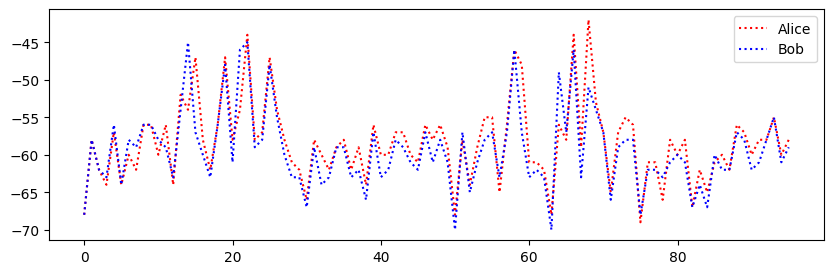

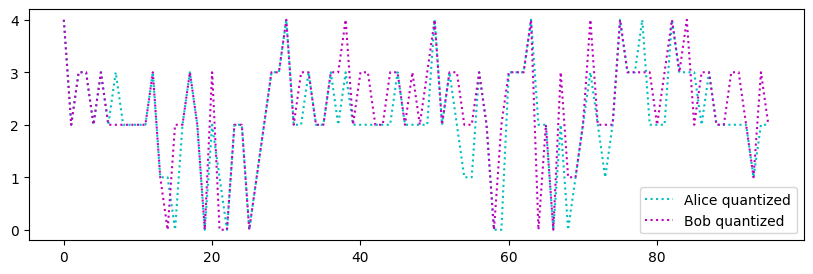

In [83]:
import matplotlib.pyplot as plt
samples=[[-68, -68], [-58, -58], [-62, -62], [-64, -63], [-57, -56], [-64, -64], [-60, -58], [-62, -59], [-56, -56], [-56, -56], [-60, -58], [-56, -59], [-64, -63], [-52, -54], [-54, -45], [-47, -57], [-58, -60], [-62, -63], [-56, -56], [-47, -48], [-58, -61], [-54, -46], [-44, -45], [-58, -59], [-57, -58], [-47, -48], [-54, -55], [-58, -60], [-61, -63], [-62, -63], [-66, -67], [-58, -59], [-60, -64], [-62, -63], [-59, -59], [-58, -59], [-62, -63], [-59, -62], [-64, -66], [-56, -57], [-60, -63], [-60, -62], [-57, -58], [-57, -59], [-60, -61], [-61, -62], [-56, -57], [-58, -61], [-56, -58], [-59, -61], [-68, -70], [-58, -57], [-64, -65], [-59, -61], [-55, -58], [-55, -57], [-65, -63], [-56, -57], [-46, -46], [-48, -57], [-61, -63], [-61, -62], [-62, -63], [-68, -70], [-56, -49], [-58, -57], [-44, -46], [-59, -63], [-42, -51], [-53, -54], [-57, -57], [-65, -66], [-57, -59], [-55, -58], [-56, -58], [-69, -68], [-61, -62], [-61, -62], [-66, -63], [-58, -61], [-60, -60], [-58, -61], [-67, -67], [-62, -64], [-65, -67], [-61, -60], [-60, -62], [-62, -62], [-56, -57], [-57, -58], [-60, -62], [-58, -61], [-58, -58], [-55, -55], [-60, -61], [-58, -59]]

alice = [x[0] for x in samples]
bob = [x[1] for x in samples]
plt.figure(figsize=(10,3))
plt.plot(alice, 'r:', label="Alice")
plt.plot(bob, 'b:', label="Bob")
plt.legend()
plt.show()

quantization_margins = [0, -50, -55, -60, -65, -128]

alice_q = []
for s in alice:
    for i in range(len(quantization_margins)-1):
        if(s<quantization_margins[i] and s>=quantization_margins[i+1]):
            alice_q.append(i)
bob_q = []
for s in bob:
    for i in range(len(quantization_margins)-1):
        if(s<quantization_margins[i] and s>=quantization_margins[i+1]):
            bob_q.append(i)

plt.figure(figsize=(10,3))
plt.plot(alice_q, 'c:', label="Alice quantized")
plt.plot(bob_q, 'm:', label="Bob quantized")
plt.legend()
plt.show()



[18, 15, 11, 11, 10, 10, 7, 2, 11, 4, 5, 2, 4, 6, 15, 18, 11, 10, 14, 14, 10, 10, 11, 10, 10, 18, 14, 3, 14, 0, 15, 28, 10, 2, 1, 11, 5, 20, 15, 18, 10, 19, 15, 11, 10, 10, 5, 10]
[18, 15, 11, 10, 10, 10, 7, 2, 11, 4, 6, 2, 4, 6, 15, 18, 15, 10, 15, 18, 15, 10, 15, 11, 11, 18, 15, 10, 14, 2, 15, 28, 2, 3, 3, 20, 10, 20, 15, 15, 11, 19, 18, 15, 10, 15, 5, 14]


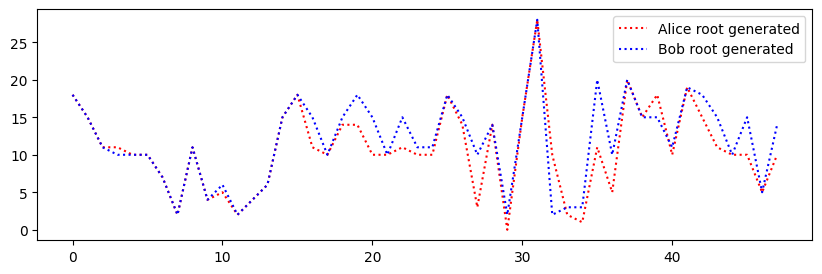

[4, 6, 15, 18, 11, 10] [4, 6, 15, 18, 15, 10]
[1, -64, 1637, -21326, 148452, -520200, 712800] [1, -64, 1637, -21326]


[[1, -64, 1637, -21326, 148452, -520200, 712800]]

In [84]:
window = 2
alice_roots = []
for i in range(0, len(alice_q), window):
    sequence = alice_q[i: i+window]
    binary_string = ''.join(format(num, 'b') for num in sequence)
    alice_root = int(binary_string, 2)
    alice_roots.append(alice_root)
print(alice_roots)

bob_roots = []
for i in range(0, len(bob_q), window):
    sequence = bob_q[i: i+window]
    binary_string = ''.join(format(num, 'b') for num in sequence)
    bob_root = int(binary_string, 2)
    bob_roots.append(bob_root)
print(bob_roots)

plt.figure(figsize=(10,3))
plt.plot(alice_roots, 'r:', label="Alice root generated")
plt.plot(bob_roots, 'b:', label="Bob root generated")
plt.legend()
plt.show()

##########################################

i = 12
window = 6
w_1 = alice_roots[i:i+window]
w_2 = bob_roots[i:i+window]

print(w_1, w_2)
s = len(w_1)
t = 3 #### HOW TO DETERMINE t (number of coeffs after 1 to share with second device)

#print(w_1, w_2)

sent_coeffs = poly_coeff_from_roots(w_1)[:t+1]
print(poly_coeff_from_roots(w_1), sent_coeffs)

get_coeff_list(c=sent_coeffs, w=w_2, t=t, v=2)

___


# Complete Usage

In [85]:
import numpy as np

def spline_projection(seq):
    projected_seq = []
    for i in range(1, len(alice)-1, 1):
        A = np.array(
            [[(i-1)**3, (i-1)**2, (i-1)**1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, i**3, i**2, i**1, 1],
            [i**3, i**2, i**1, 1, 0, 0, 0, 0],
            [(i+1)**3, (i+1)**2, (i+1)**1, 1, 0, 0, 0, 0],
            [3*i**2, 2*i, 1, 0, -3*i**2, -2*i, -1, 0],
            [6*i, 2, 0, 0, -6*i, -2, 0, 0],
            [6*(i-1), 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 6*(i+1), 2, 0, 0]]
        )
        b = np.array([seq[i-1], seq[i], seq[i], seq[i+1], 0, 0, 0, 0])
        coeff = np.dot(np.linalg.inv(A), b)
        
        #print(np.linalg.det(A))
        #print(np.dot(np.linalg.inv(A), b))
        #print(i)

        k = i+2
        # projected cubic eq.
        projected_seq.append( round(coeff[0]*k**3 + coeff[1]*k**2 + coeff[2]*k**1 + coeff[3]) )
        projected_seq.append( round(coeff[4]*k**3 + coeff[5]*k**2 + coeff[6]*k**1 + coeff[7]) )
    return projected_seq

# print(spline_projection(alice))
# print()
# print(spline_projection(bob))

In [86]:
def quantization_percent(data, m):
    #m = int((len(data)/2)) #int((len(data)/2)+2)
    #print(m, len(data))
    quantiles = np.percentile(data, np.linspace(0, 100, m + 1))
    #print(quantiles)
    ranges = []
    for i in range(len(quantiles) - 1):
        ranges.append((quantiles[i], quantiles[i + 1]))

    number_ranges = []
    for num in data:
        for i, (start, end) in enumerate(ranges):
            if start <= num <= end:
                number_ranges.append((num, i + 1)) 
                break

    quant_seq = []
    for num, rng in number_ranges:
        #print(format(rng, f'0{round(m/2)-1}b')) #int
        #print(rng)
        quant_seq.append(rng)
    return quant_seq

[[1, -19, 153, -681, 1830, -3036, 3032, -1664, 384]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]
[[1, -19, 153, -681, 1830, -3036, 3032, -1664, 384]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]
[[1, -19, 152, -666, 1741, -2771, 2618, -1344, 288]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]
[[1, -19, 154, -694, 1897, -3211, 3276, -1836, 432]]
[[1, -19, 153, -681, 1830, -3036, 3032, -1664, 384]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]
[[1, -20, 170, -800, 2273, -3980, 4180, -2400, 576]]


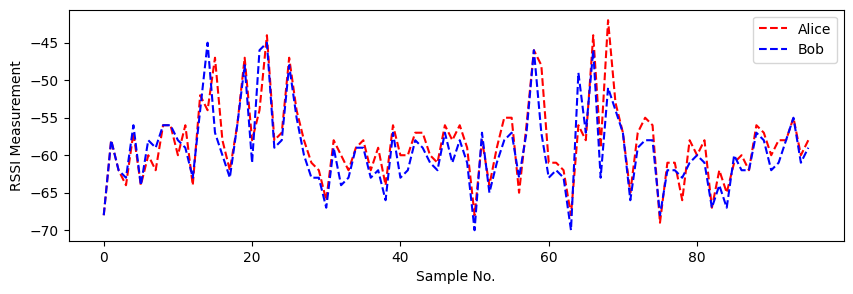

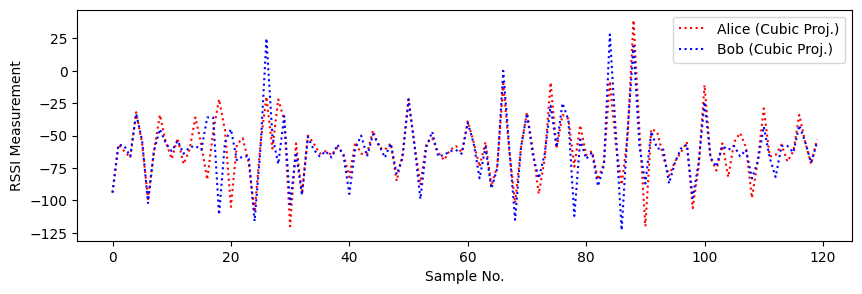

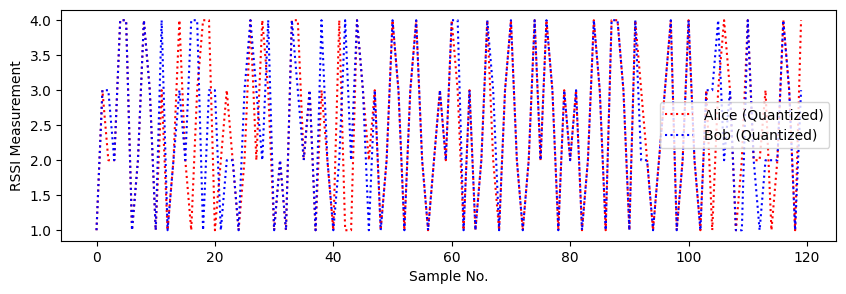

In [118]:
samples=[[-68, -68], [-58, -58], [-62, -62], [-64, -63], [-57, -56], [-64, -64], [-60, -58], [-62, -59], [-56, -56], [-56, -56], [-60, -58], [-56, -59], [-64, -63], [-52, -54], [-54, -45], [-47, -57], [-58, -60], [-62, -63], [-56, -56], [-47, -48], [-58, -61], [-54, -46], [-44, -45], [-58, -59], [-57, -58], [-47, -48], [-54, -55], [-58, -60], [-61, -63], [-62, -63], [-66, -67], [-58, -59], [-60, -64], [-62, -63], [-59, -59], [-58, -59], [-62, -63], [-59, -62], [-64, -66], [-56, -57], [-60, -63], [-60, -62], [-57, -58], [-57, -59], [-60, -61], [-61, -62], [-56, -57], [-58, -61], [-56, -58], [-59, -61], [-68, -70], [-58, -57], [-64, -65], [-59, -61], [-55, -58], [-55, -57], [-65, -63], [-56, -57], [-46, -46], [-48, -57], [-61, -63], [-61, -62], [-62, -63], [-68, -70], [-56, -49], [-58, -57], [-44, -46], [-59, -63], [-42, -51], [-53, -54], [-57, -57], [-65, -66], [-57, -59], [-55, -58], [-56, -58], [-69, -68], [-61, -62], [-61, -62], [-66, -63], [-58, -61], [-60, -60], [-58, -61], [-67, -67], [-62, -64], [-65, -67], [-61, -60], [-60, -62], [-62, -62], [-56, -57], [-57, -58], [-60, -62], [-58, -61], [-58, -58], [-55, -55], [-60, -61], [-58, -59]]

cubic_A_all = []
cubic_B_all = []

quant_A_all = []
quant_B_all = []



for i in range(0, len(samples)-6, 6):
    alice = [x[0] for x in samples][i:i+6]
    bob = [x[1] for x in samples][i:i+6]
    #print(alice, bob)

    c_A = spline_projection(alice)
    c_B = spline_projection(bob)
    cubic_A_all.append(c_A)
    cubic_B_all.append(c_B)


    # quantization
    q_A = quantization_percent(c_A, round(len(c_A)/2))
    q_B = quantization_percent(c_B, round(len(c_B)/2))
    quant_A_all.append(q_A)
    quant_B_all.append(q_B)
 

    # Alice - JS encoding
    alice_coeffs = poly_coeff_from_roots(q_A)        #[:t+1]
    t = int(len(alice_coeffs)/2)
    #print(poly_coeff_from_roots(q_A), alice_coeffs)
    #print(alice_coeffs)

    # Bob - JS decoding
    print(get_coeff_list(c=alice_coeffs[:t+1], w=q_B, t=t, v=2)) # v is variations inside the decoder

alice = [x[0] for x in samples]
bob = [x[1] for x in samples]

plt.figure(figsize=(10, 3))
plt.plot(alice, 'r--', label="Alice")
plt.plot(bob, 'b--', label="Bob")
plt.xlabel("Sample No.")
plt.ylabel("RSSI Measurement")
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(np.array(cubic_A_all).flatten(), 'r:', label="Alice (Cubic Proj.)")
plt.plot(np.array(cubic_B_all).flatten(), 'b:', label="Bob (Cubic Proj.)")
plt.xlabel("Sample No.")
plt.ylabel("RSSI Measurement")
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(np.array(quant_A_all).flatten(), 'r:', label="Alice (Quantized)")
plt.plot(np.array(quant_B_all).flatten(), 'b:', label="Bob (Quantized)")
plt.xlabel("Sample No.")
plt.ylabel("RSSI Measurement")
plt.legend()
plt.show()